# Tension Model Test and Explanation
This notebook demonstrates the process of calculating musical tension using the 'tension ribbons' model. We will:
1. Generate a sample musical piece (harmony and melody).
2. Transform the musical data into a format suitable for the tension model (spiral array representation).
3. Apply the tension model to calculate various tension components (cloud diameter, cloud momentum, tensile strain).
4. Visualize the calculated tension values.

## 1. Setup and Imports
Import necessary libraries and modules. This includes utilities for harmony generation, the tension model itself, and plotting tools.

In [5]:
import sys
sys.path.insert(0, '../')

In [6]:
from harmony_grammar import *
from utils import *
from genetic_algorithm import *
from tension_model.tension_ribbons import *
import pickle
import matplotlib.pyplot as plt


## 2. Generate Musical Material
First, we generate a harmonic progression using `HarmonyGrammar` and load some pre-defined musical motifs.

In [7]:
grammar = HarmonyGrammar()

In [8]:
all_progressions = grammar.generate_all_progressions(min_length=8, max_length=8, max_depth=5)

Let's pick one of these progressions and print its tree structure to see the generated harmony.

In [9]:
all_progressions[3].print_tree()

└── TR
    ├── TR
    │   ├── TR
    │   │   ├── TR
    │   │   │   └── t
    │   │   └── DR
    │   │       └── d
    │   └── DR
    │       ├── DR
    │       │   └── d
    │       └── DR
    │           └── d
    └── DR
        ├── DR
        │   ├── SR
        │   │   └── s
        │   └── d
        └── DR
            ├── SR
            │   └── s
            └── d


In [10]:
motif_hero = pickle.load(open("motif_hero.pkl", "rb"))
motif_villain = pickle.load(open("motif_villain.pkl", "rb"))

## 3. Create a Musical Piece (MusicalNode)
We select a random harmonic progression and combine it with motifs to create a `MusicalNode`. This node represents our musical piece with both harmony and melody.

In [16]:
tree = random.choice(all_progressions)

In [35]:
target_length_bars = 8
motif_length_bars = 2
motifs = [motif_hero, motif_villain]
protagonist_index = 0
key = Key(NOTE_TO_ROOT[motifs[protagonist_index].key], motifs[protagonist_index].is_major)
print("Key is:" + ROOT_TO_NOTE[key.root] + "Maj" if key.is_major else "Min")
for motif in motifs:
    motif.transpose(ROOT_TO_NOTE[key.root], key.is_major)
num_repetitions = target_length_bars // motif_length_bars
print("Num repetitions: " + str(num_repetitions))
arrangements = list(itertools.product(motifs, repeat=num_repetitions))
print("Num arrangements: " + str(len(arrangements)))

Key is:CMaj
Num repetitions: 4
Num arrangements: 16


In [36]:
node = MusicalNode.from_tree_node(tree, key)
node.assign_motifs_melody_to_terminals(arrangements[0])

Let's view the structure of the `MusicalNode` and the resulting chord progression.

In [37]:
node.print_tree()

└── TR (C, maj)
    ├── TR (C, maj)
    │   ├── TR (C, maj)
    │   │   ├── TR (C, maj)
    │   │   │   └── t (C, maj)
    │   │   └── DR (C, maj)
    │   │       └── d (C, maj)
    │   └── DR (C, maj)
    │       ├── SR (C, maj)
    │       │   └── s (C, maj)
    │       └── d (C, maj)
    └── TR (C, maj)
        ├── TR (C, maj)
        │   ├── TR (C, maj)
        │   │   └── t (C, maj)
        │   └── DR (C, maj)
        │       └── d (C, maj)
        └── DR (C, maj)
            ├── SR (C, maj)
            │   └── s (C, maj)
            └── d (C, maj)


In [38]:
if 'node' in locals():
    terminals = node.get_terminal_nodes()

In [39]:
if 'terminals' in locals():
    print("Chord Progression (Terminal Symbols):")
    print([terminal.symbol for terminal in terminals])

Chord Progression (Terminal Symbols):
[<Symbol.t: 't'>, <Symbol.d: 'd'>, <Symbol.s: 's'>, <Symbol.d: 'd'>, <Symbol.t: 't'>, <Symbol.d: 'd'>, <Symbol.s: 's'>, <Symbol.d: 'd'>]


## 4. Prepare Data for Tension Model
The tension model requires musical data (pitches) to be represented in a specific format. We extract all notes (harmony and melody) per time step (e.g., 16th note).

In [51]:
all_bars = node.get_harmony_melody_notes()
all_bars_notes = [note[0] for note in all_bars]

### 4.1. Spiral Array Transformation
Notes are transformed into positions in a 3D spiral array. This representation captures tonal relationships. We also determine the position of the current key in this spiral array.

In [52]:
if 'all_bars_notes' in locals() and all_bars_notes:
    # Example transformation for the first few time steps
    position_1 = notes_to_spiral_array(all_bars_notes[0])
    print("Spiral array for notes at time step 1: ", position_1)
    if len(all_bars_notes) > 1:
        position_2 = notes_to_spiral_array(all_bars_notes[1])
        print("Spiral array for notes at time step 2:", position_2)
else:
    print("Skipping spiral array transformation example as 'all_bars_notes' is not available or empty.")

Spiral array for notes at time step 1:  [[0.  1.  0. ]
 [0.  1.  1.6]
 [1.  0.  0.4]]
Spiral array for notes at time step 2: [[ 0.   1.   0. ]
 [ 0.   1.   1.6]
 [-1.   0.  -0.4]
 [ 1.   0.   0.4]]


In [53]:
if 'key' in locals():
    if key.is_major:
        key_spiral_position = major_key_position(NOTE_TO_ROOT[ROOT_TO_NOTE[key.root]])
    else:
        key_spiral_position = minor_key_position(NOTE_TO_ROOT[ROOT_TO_NOTE[key.root]])
    print(f"Spiral array position for the key ({ROOT_TO_NOTE[key.root]} {'Major' if key.is_major else 'Minor'}):", key_spiral_position)

Spiral array position for the key (C Major): [0.16988 0.4182  0.548  ]


### 4.2. Understanding Key Chords
Let's look at the notes forming the basic chords (triads) in our current key. This helps in understanding the tonal context.

In [54]:
print("I chord: ", [ROOT_TO_NOTE[note] for note in key.get_chord(SCALE_DEGREES_INDEX['I'])])
print("II chord: ", [ROOT_TO_NOTE[note] for note in key.get_chord(SCALE_DEGREES_INDEX['II'])])
print("III chord: ", [ROOT_TO_NOTE[note] for note in key.get_chord(SCALE_DEGREES_INDEX['III'])])
print("IV chord: ", [ROOT_TO_NOTE[note] for note in key.get_chord(SCALE_DEGREES_INDEX['IV'])])
print("V chord: ", [ROOT_TO_NOTE[note] for note in key.get_chord(SCALE_DEGREES_INDEX['V'])])
print("VI chord: ", [ROOT_TO_NOTE[note] for note in key.get_chord(SCALE_DEGREES_INDEX['VI'])])
print("VII chord: ", [ROOT_TO_NOTE[note] for note in key.get_chord(SCALE_DEGREES_INDEX['VII'])])

I chord:  ['C', 'E', 'G']
II chord:  ['D', 'F', 'A']
III chord:  ['E', 'G', 'B']
IV chord:  ['F', 'A', 'C']
V chord:  ['G', 'B', 'D']
VI chord:  ['A', 'C', 'E']
VII chord:  ['B', 'D', 'F']


## 5. Tension Model Components
The tension model calculates several components. Let's examine `tensile_strain` and then the full `calculate_tension` function.

### 5.1. Tensile Strain Example
Tensile strain measures the distance between the center of effect of currently sounding notes and the center of effect of the key.

In [48]:
if 'position_1' in locals() and 'key_spiral_position' in locals():
    strain_1 = calculate_tensile_strain(position_1, key_spiral_position)
    print(f"Tensile strain for notes at time step 1: {strain_1:.4f}")
    if 'position_2' in locals():
        strain_2 = calculate_tensile_strain(position_2, key_spiral_position)
        print(f"Tensile strain for notes at time step 2: {strain_2:.4f}")
else:
    print("Skipping tensile strain example as required variables are not available.")

Tensile strain for notes at time step 1: 0.1769
Tensile strain for notes at time step 2: 0.0787


### 5.2. `calculate_tension` with Known Chords
Let's test `calculate_tension` with simple, known chords to understand its output. The function returns cloud diameter, cloud momentum, and tensile strain for each time step (here, each chord is a time step).

In [49]:
print("Tension Values for I in C Major (notes: C, E, G -> 0, 4, 7):")
cd, cm, ts = calculate_tension([[0, 4, 7]], key_root=0, is_major=True)
print(f"  Cloud Diameter: {cd[0]:.4f}, Cloud Momentum: {cm[0]:.4f}, Tensile Strain: {ts[0]:.4f}")

print("Tension Values for V in C Major (notes: G, B, D -> 7, 11, 2):")
cd, cm, ts = calculate_tension([[7, 11, 2]], key_root=0, is_major=True)
print(f"  Cloud Diameter: {cd[0]:.4f}, Cloud Momentum: {cm[0]:.4f}, Tensile Strain: {ts[0]:.4f}")

print("Tension Values for I in C Minor (notes: C, Eb, G -> 0, 3, 7):")
cd, cm, ts = calculate_tension([[0, 3, 7]], key_root=0, is_major=False)
print(f"  Cloud Diameter: {cd[0]:.4f}, Cloud Momentum: {cm[0]:.4f}, Tensile Strain: {ts[0]:.4f}")

Tension Values for I in C Major (notes: C, E, G -> 0, 4, 7):
  Cloud Diameter: 1.8547, Cloud Momentum: 0.0000, Tensile Strain: 0.1769
Tension Values for V in C Major (notes: G, B, D -> 7, 11, 2):
  Cloud Diameter: 1.8547, Cloud Momentum: 0.0000, Tensile Strain: 0.0880
Tension Values for I in C Minor (notes: C, Eb, G -> 0, 3, 7):
  Cloud Diameter: 1.8547, Cloud Momentum: 0.0000, Tensile Strain: 0.7543


## 6. Apply Full Tension Model to Generated Music
Now, we apply the `calculate_tension` function to the entire musical piece generated earlier.

In [55]:
if 'all_bars_notes' in locals() and 'node' in locals() and all_bars_notes:
    cloud_diameter, cloud_momentum, tensile_strain = calculate_tension(all_bars_notes, node.key.root, node.key.is_major)
    print("Tension components calculated for the generated piece.")
else:
    print("Skipping full tension calculation as 'all_bars_notes' or 'node' is not available or 'all_bars_notes' is empty.")

Tension components calculated for the generated piece.


## 7. Visualize Tension
We plot the calculated tension components (cloud diameter, cloud momentum, tensile strain) over time. We also compute and plot some aggregate statistics like average tension.

In [56]:
tensions = np.array([cloud_diameter, cloud_momentum, tensile_strain])
tension = np.average(tensions, axis=0)
tension_max = np.max(tensions, axis=0)
tension_min = np.min(tensions, axis=0)
tension_std = np.std(tensions, axis=0)

tension_stats = np.array([tension, tension_max, tension_min, tension_std])

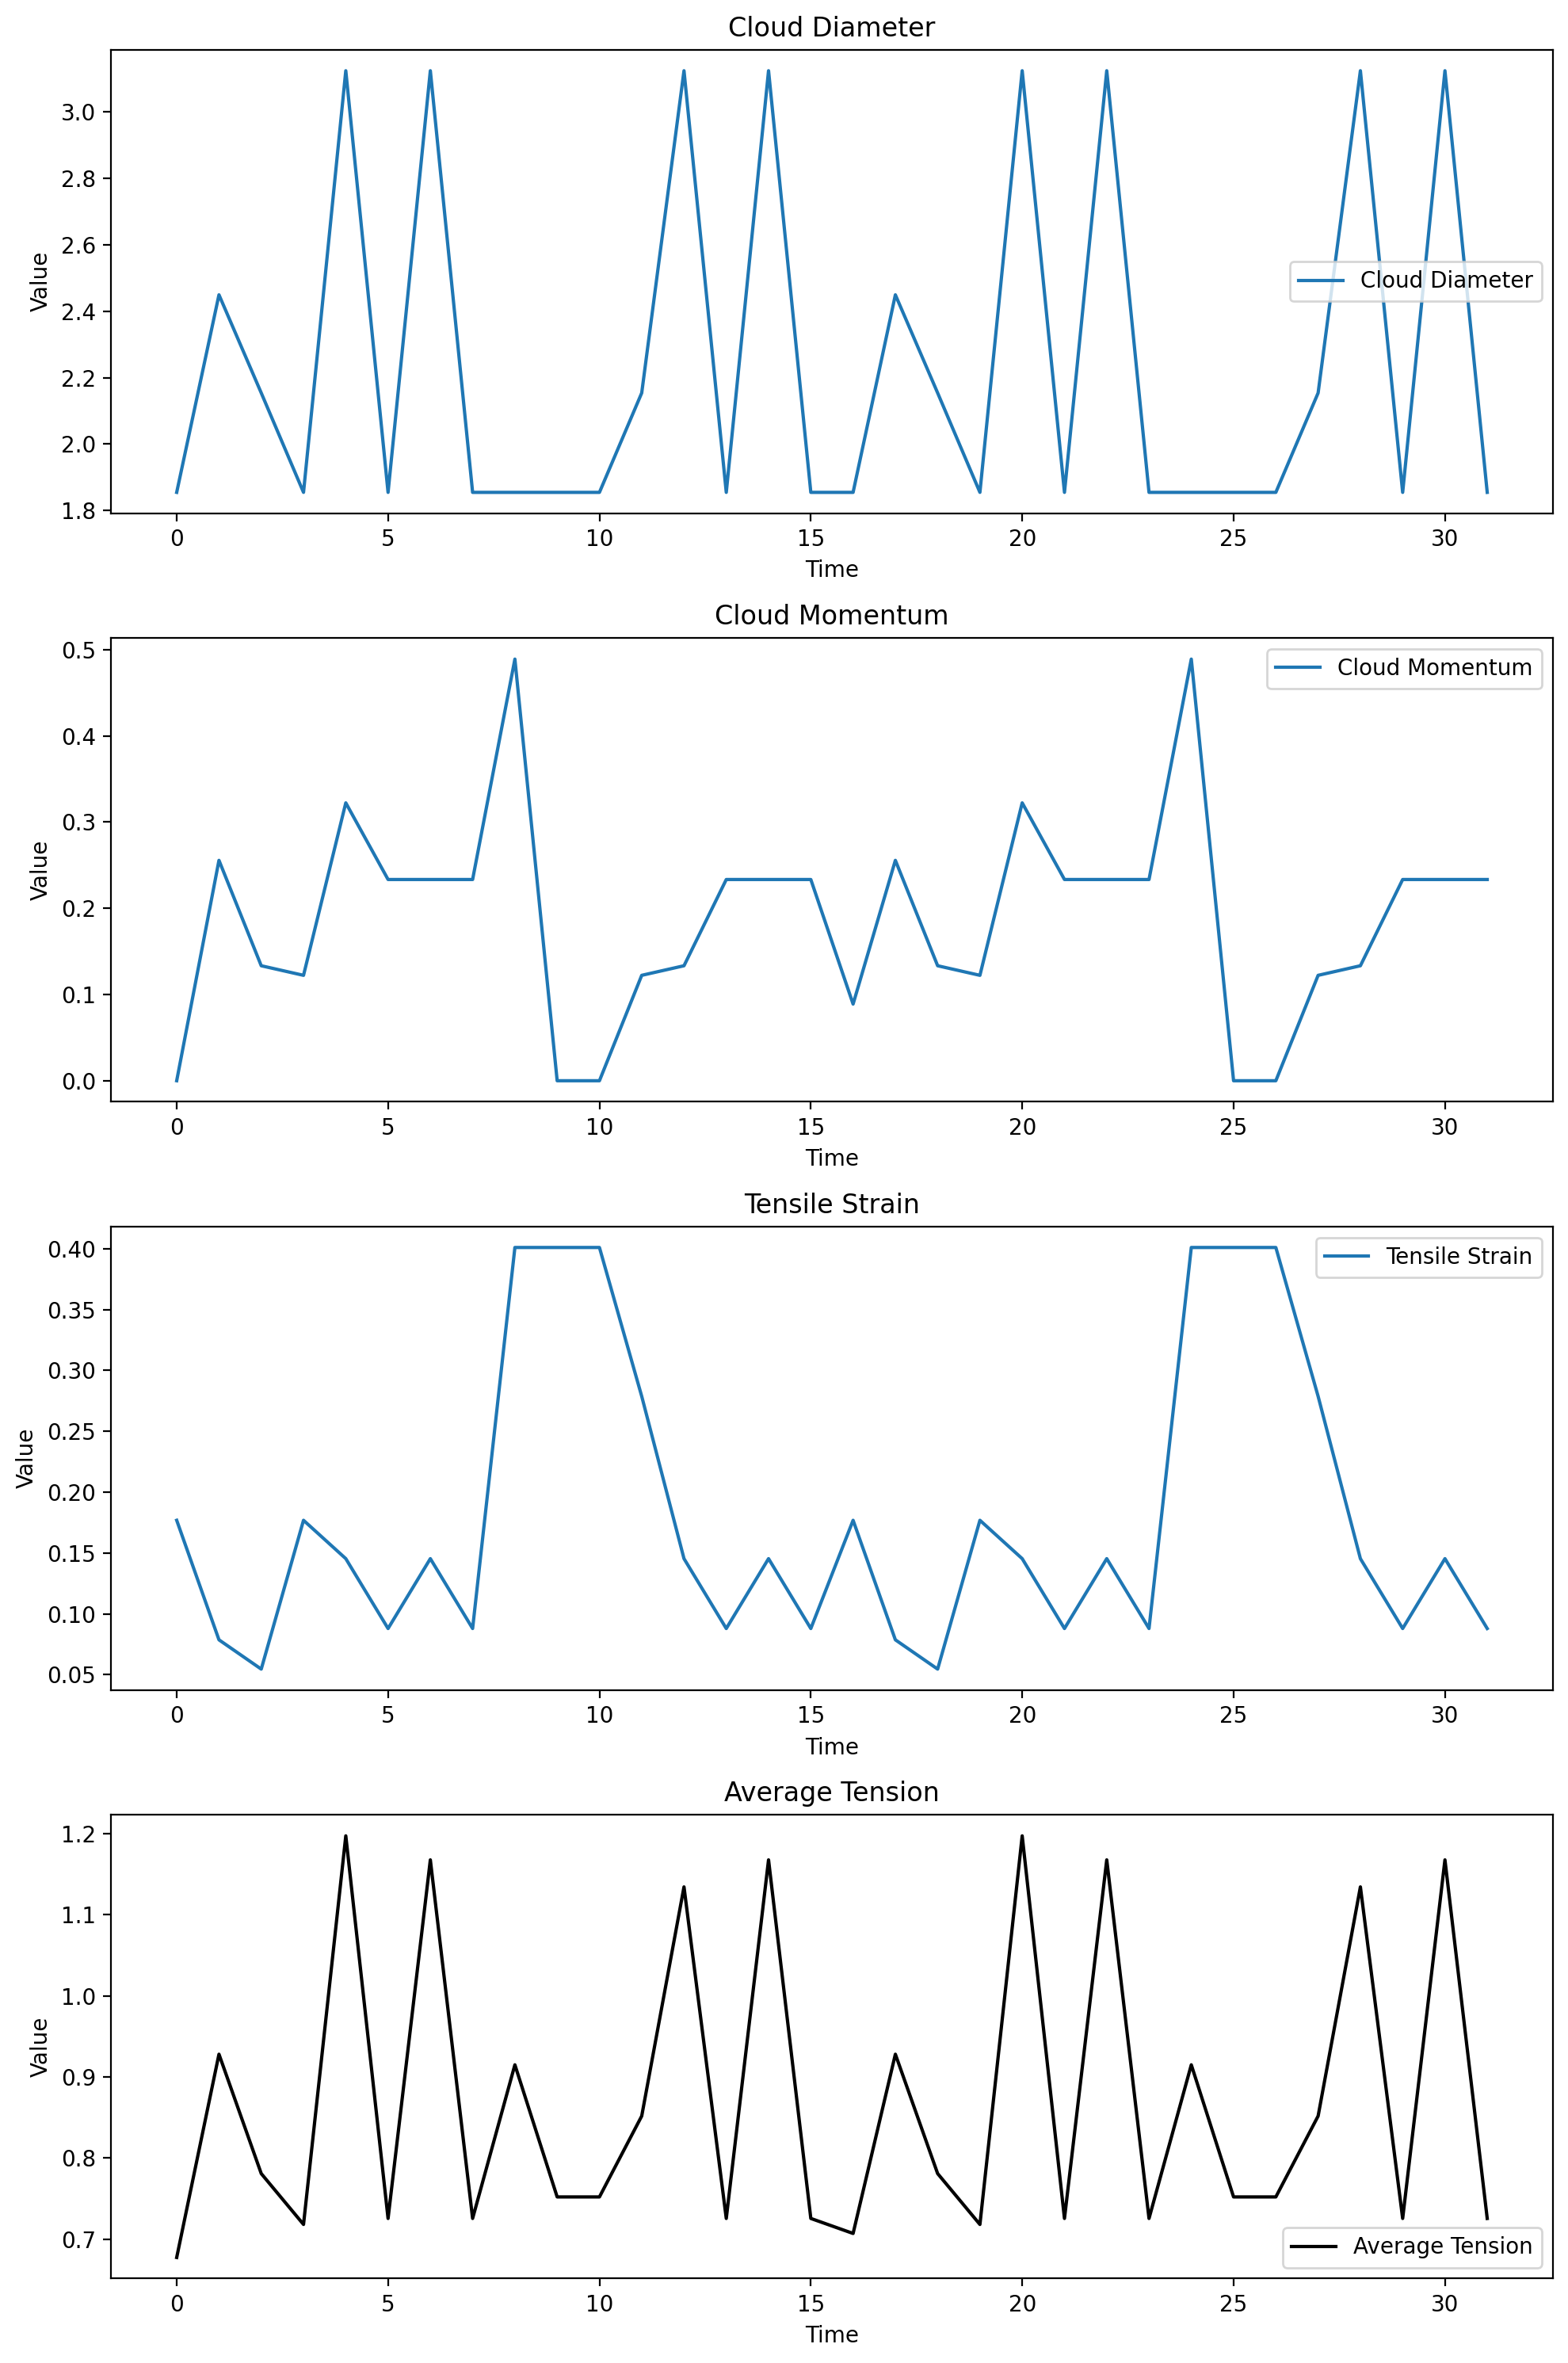

In [57]:
labels = ['Cloud Diameter', 'Cloud Momentum', 'Tensile Strain']
x = range(len(tensions[0]))

fig, axs = plt.subplots(4, 1, figsize=(10, 15))

for i in range(3):
    axs[i].plot(x, tensions[i], label=labels[i])
    axs[i].set_title(labels[i])
    axs[i].set_xlabel('Time')
    axs[i].set_ylabel('Value')
    axs[i].legend()

axs[3].plot(x, tension, label='Average Tension', color='black')
axs[3].set_title('Average Tension')
axs[3].set_xlabel('Time')
axs[3].set_ylabel('Value')
axs[3].legend()

plt.tight_layout()
plt.show()

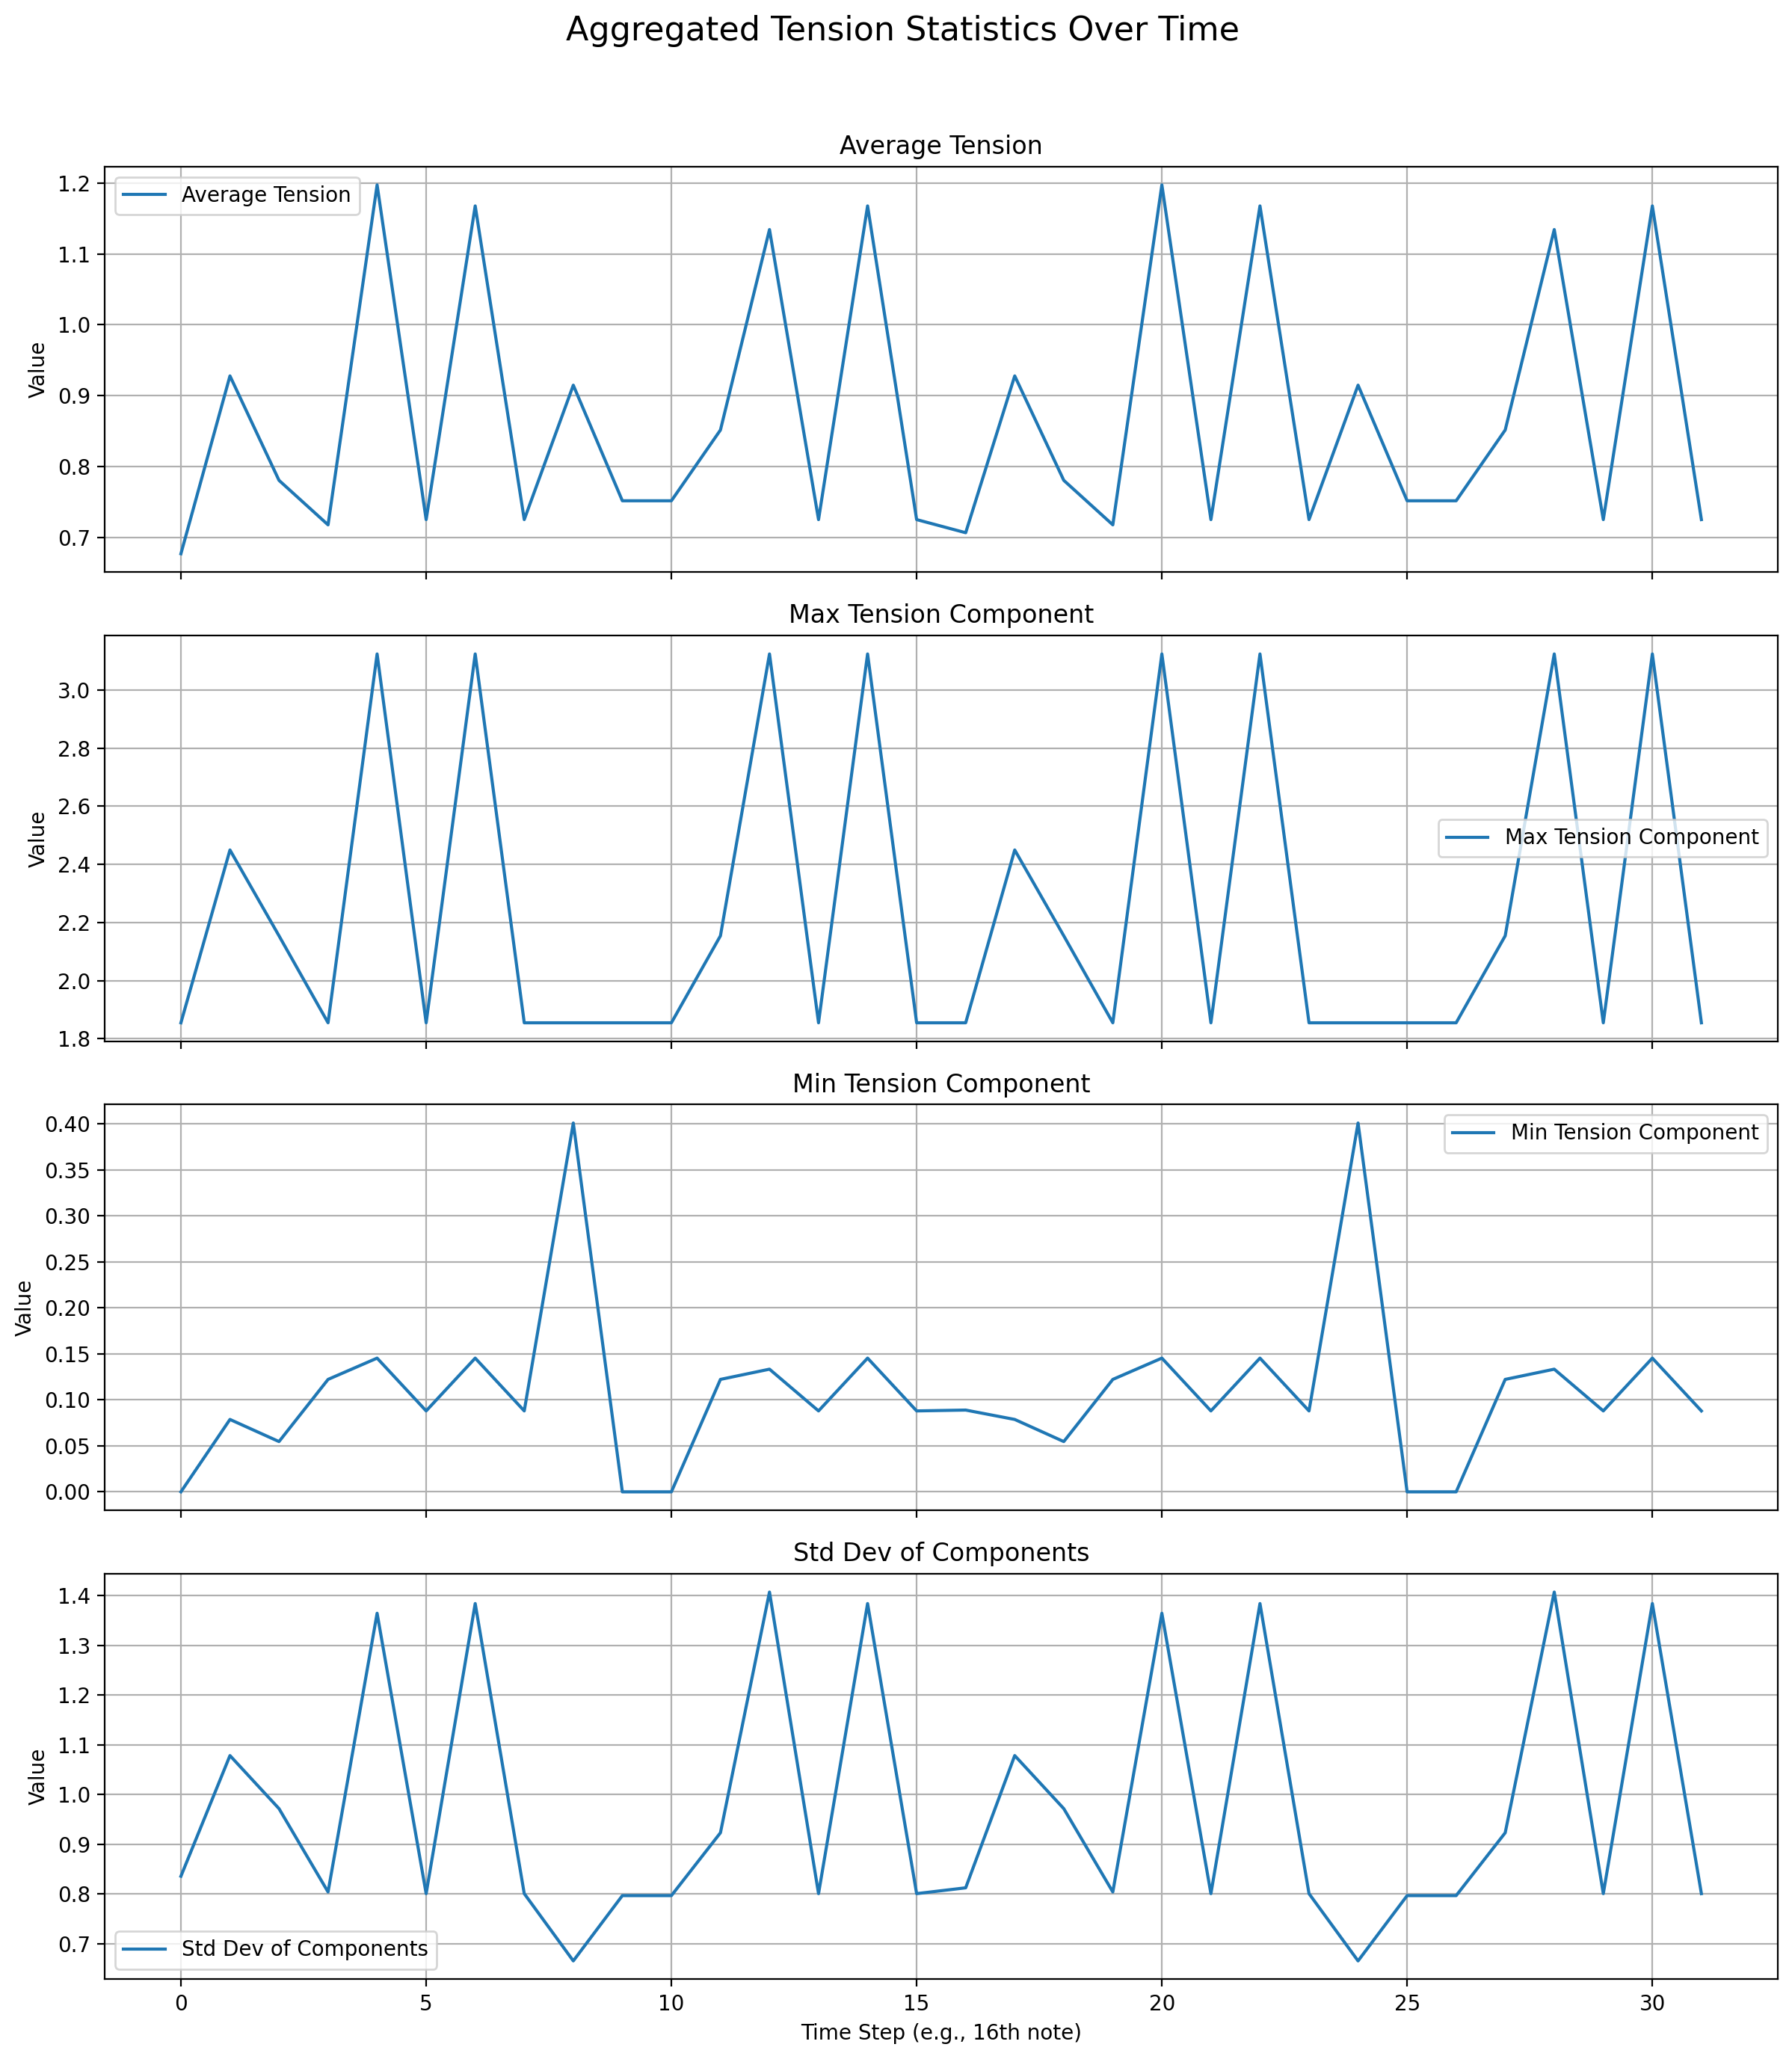

In [58]:
if 'tension_stats' in locals():
    stat_labels = ['Average Tension', 'Max Tension Component', 'Min Tension Component', 'Std Dev of Components']
    time_steps = range(len(tension_stats[0]))

    fig, axs = plt.subplots(4, 1, figsize=(12, 14), sharex=True)
    fig.suptitle('Aggregated Tension Statistics Over Time', fontsize=16)

    for i in range(4):
        axs[i].plot(time_steps, tension_stats[i], label=stat_labels[i])
        axs[i].set_title(stat_labels[i])
        axs[i].set_ylabel('Value')
        axs[i].legend()
        axs[i].grid(True)

    axs[3].set_xlabel('Time Step (e.g., 16th note)')
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()
else:
    print("Skipping plot of tension statistics.")

## 8. Conclusion
This notebook walked through the generation of musical material, its transformation into the spiral array representation, and the application of the tension ribbons model. By examining the individual components (cloud diameter, cloud momentum, tensile strain) and their aggregation, we can gain insights into the perceived tension of a musical piece as predicted by this model. The visualizations help in understanding how these tension metrics evolve over the duration of the music.